In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats

In [3]:
df_movie = pd.read_csv("Expanded_data/big_data_final.tsv",sep='\t')
print(df_movie.shape)
df_movie.head()

/var/folders/zk/q88v15sn4znchrthdv128s940000gn/T/ipykernel_1575/1739072153.py:1: DtypeWarning: Columns (0,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df_movie = pd.read_csv("Expanded_data/big_data_final.tsv",sep='\t')


(9383379, 13)


,Freebase movie ID,IMDB_id,Movie box office revenue,Movie genres names,Movie name,Movie release date,averageRating,budget,numVotes,prod_country,inflation coeff,inflation corrected revenue,inflation corrected budget
0,/m/0100_m55,tt0138297,NaN,"['Comedy', 'Sci-Fi']",Urban Animals,1987.0,5.2,NaN,79.0,NaN,2.384772,NaN,NaN
1,/m/0100_mnm,tt0202813,NaN,['Comedy'],NaN,1999.0,5.8,NaN,15.0,NaN,1.626713,NaN,NaN
2,/m/0100_nzr,tt0184302,NaN,['Drama'],NaN,1999.0,4.8,NaN,119.0,NaN,1.626713,NaN,NaN
3,/m/0100_pgp,tt0094831,NaN,['Comedy'],NaN,1988.0,6.8,NaN,103.0,NaN,2.291337,NaN,NaN
4,/m/0100_pz9,tt0088884,NaN,['Comedy'],NaN,1985.0,2.4,NaN,59.0,NaN,2.519087,NaN,NaN


### Genre distribution

In [57]:
df_genre = df_movie.copy()
df_genre.dropna(subset=['Movie genres names'])

,Freebase movie ID,IMDB_id,Movie box office revenue,Movie genres names,Movie name,Movie release date,averageRating,budget,numVotes,prod_country,inflation coeff,inflation corrected revenue,inflation corrected budget
0,/m/0100_m55,tt0138297,NaN,"['Comedy', 'Sci-Fi']",Urban Animals,1987.0,5.2,NaN,79.0,NaN,2.384772,NaN,NaN
1,/m/0100_mnm,tt0202813,NaN,['Comedy'],NaN,1999.0,5.8,NaN,15.0,NaN,1.626713,NaN,NaN
2,/m/0100_nzr,tt0184302,NaN,['Drama'],NaN,1999.0,4.8,NaN,119.0,NaN,1.626713,NaN,NaN
3,/m/0100_pgp,tt0094831,NaN,['Comedy'],NaN,1988.0,6.8,NaN,103.0,NaN,2.291337,NaN,NaN
4,/m/0100_pz9,tt0088884,NaN,['Comedy'],NaN,1985.0,2.4,NaN,59.0,NaN,2.519087,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9383374,NaN,tt9916848,NaN,"['Action', 'Drama', 'Family']",NaN,2010.0,NaN,NaN,NaN,NaN,1.242664,NaN,NaN
9383375,NaN,tt9916850,NaN,"['Action', 'Drama', 'Family']",NaN,2010.0,NaN,NaN,NaN,NaN,1.242664,NaN,NaN
9383376,NaN,tt9916852,NaN,"['Action', 'Drama', 'Family']",NaN,2010.0,NaN,NaN,NaN,NaN,1.242664,NaN,NaN
9383377,NaN,tt9916856,NaN,['Short'],NaN,2015.0,NaN,NaN,NaN,NaN,1.143250,NaN,NaN


In [55]:
type(df_genre['Movie genres names'].iloc[4103])

float

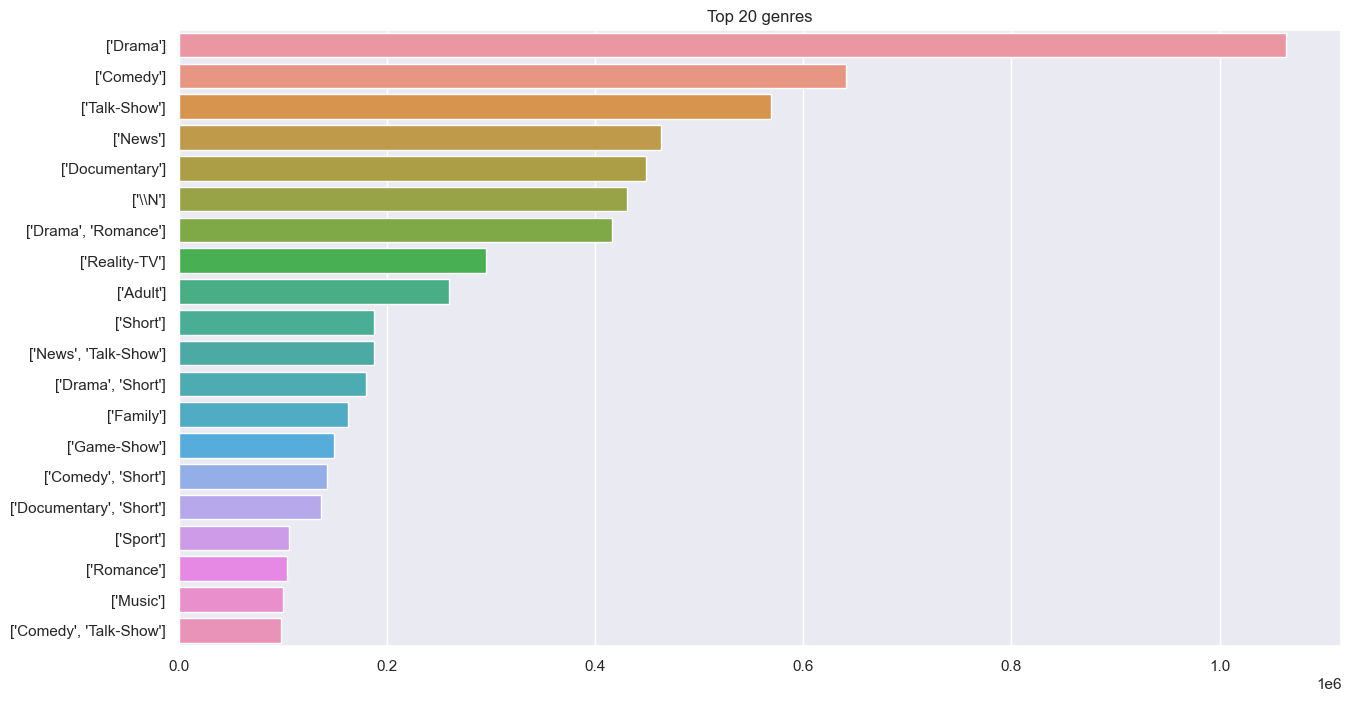

In [64]:
#remove nan


def func_genre(g) :
    if isinstance(g, list) :
        if '\\N' in g :
            print('s')
            return float('nan')
    return g

df_genre['Movie genres names'] = df_genre['Movie genres names'].apply(lambda x : func_genre(x))

#df_genre.replace(['\\N'], float('nan'), inplace=True)

#print(sum(df_genre['Movie genres names'] == ['\\N']))
#df_genre = df_movie.dropna(subset=['Movie genres names'])
#df_genre.replace(['\\N'], float('NaN'), inplace=True)

count_genre = df_genre['Movie genres names'].value_counts()

plt.figure(figsize=(15,8))
ax = sns.barplot(x=count_genre.values[0:20], y=count_genre.index[0:20]).set(title='Top 20 genres')
plt.show()


### Year distribution

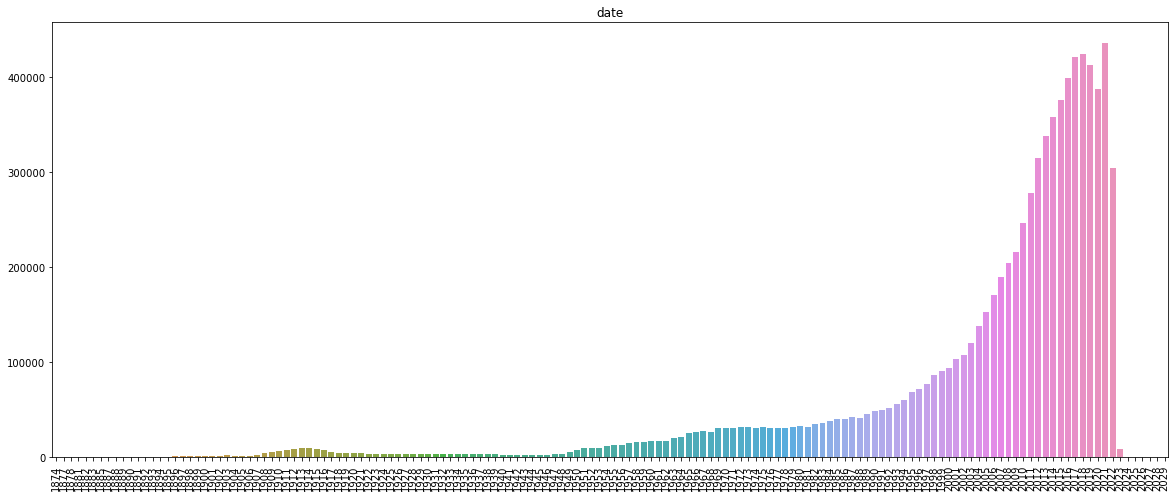

In [7]:
df_date = df_movie[~df_movie['Movie release date'].isna()]
df_date = df_date[df_date['Movie release date'] != "\\N"]

df_date['Movie release date'] = pd.to_datetime(df_date['Movie release date'], errors='coerce') # ajoute 01-01 pour ceux sans jour et mois
df_date['Movie release year'] = df_date['Movie release date'].dt.year.astype('Int64')
count_per_year = df_date['Movie release year'].value_counts()
plt.figure(figsize=(20,8))
ax = sns.barplot(x=count_per_year.index, y=count_per_year.values).set(title='date')
plt.xticks(rotation='vertical')
plt.show()

In [8]:
print(count_per_year[1896])
print(count_per_year[1897])
print(count_per_year[2023])
print(count_per_year[2024])

# 1897 : more than 1000 movies until 2023

900
1372
8472
433


### Genre per year

In [ ]:
#remove nan
df_genre_date = df_date[~df_date['genre1'].isna()]
#remove '\N' 
df_genre_date = df_genre_date[df_genre_date.genre1 != "\\N"]

MemoryError: Unable to allocate 296. MiB for an array with shape (5, 7753778) and data type object

In [ ]:
df_genre_date.groupby(['Movie release year', 'genre1']).size().unstack().plot(kind='bar', stacked=True)
#illisible

In [ ]:
# Plot relative number of genres per year

cross_tab_prop = pd.crosstab(index=df_genre_date['Movie release year'],
                             columns=df_genre_date['genre1'],
                             normalize="index")
cross_tab_prop

In [ ]:
cross_tab = pd.crosstab(index=df_genre_date['Movie release year'],
                        columns=df_genre_date['genre1'])
cross_tab

In [ ]:
cross_tab_prop.plot(kind='bar', 
                    stacked=True,  
                    figsize=(50, 6))

plt.legend(loc="upper left", ncol=2)
plt.xlabel("Movie release year")
plt.ylabel("Proportion")
plt.show()

#### Genre per year (retirer valeurs rares)

In [ ]:
# Reduce number of genres (otherwise not lisibe on the graphs)
thr_genre = 300000 #minimal number of movies with a certain genre

# Select the values where the count is less than 3 (or 5 if you like)
to_remove = count_genre[count_genre <= thr_genre].index

# Keep rows where the city column is not in to_remove
df_genre_date_thr = df_genre_date[~df_genre_date.genre1.isin(to_remove)]

In [ ]:
# print only from 1897 (more than 1000 movies)
df_genre_date_thr = df_genre_date_thr[df_genre_date_thr['Movie release year']>=1897]
df_genre_date_thr = df_genre_date_thr[df_genre_date_thr['Movie release year']<=2023]

cross_tab_prop = pd.crosstab(index=df_genre_date_thr['Movie release year'],
                             columns=df_genre_date_thr['genre1'],
                             normalize="index")
cross_tab_prop.plot(kind='bar', 
                    stacked=True,
                    colormap='tab20',
                    figsize=(50, 6))

plt.legend(loc="upper left", ncol=2)
plt.xlabel("Movie release year")
plt.ylabel("Proportion")
plt.show()

## An overview of rating and revenue

The rating is represented in the column 'averageRating' and it ranges from 0 to 10, where 10 is the best score and 0 is the lowest.

Since we want to consider both the rating and the revenu at the same time, we remove the rows that have NaN in the column 'averageRating' or 'Movie box office revenue'.

In [4]:
revenue = df_movie.copy()
revenue = revenue.dropna(subset=['Movie box office revenue', 'averageRating'])
#revenue = revenue[revenue['Movie box office revenue'].notna()]
#revenue = revenue[revenue['averageRating'].notna()]

In [5]:
revenue['averageRating'].describe()

count    9575.000000
mean        6.352543
std         1.022125
min         1.000000
25%         5.800000
50%         6.400000
75%         7.000000
max         9.300000
Name: averageRating, dtype: float64

In [6]:
revenue.head()

,Freebase movie ID,IMDB_id,Movie box office revenue,Movie genres names,Movie name,Movie release date,averageRating,budget,numVotes,prod_country,inflation coeff,inflation corrected revenue,inflation corrected budget
9,/m/0100blym,tt1441953,1800000.0,"['Biography', 'Drama', 'History']",Testament of Youth,2014.0,7.2,NaN,29157.0,GB,1.144606,2.060292e+06,NaN
33,/m/0100khzv,tt2802154,4100000.0,"['Crime', 'Drama']",Leviathan,2014.0,7.6,4000000.0,53856.0,RU,1.144606,4.692887e+06,4.578426e+06
231,/m/0105j_71,tt3079380,235700000.0,"['Action', 'Comedy']",Spy,2015.0,7.0,65000000.0,245896.0,US,1.143250,2.694641e+08,7.431127e+07
303,/m/0106bp29,tt3286560,1200000.0,"['Drama', 'Romance', 'War']",The Last Face,2016.0,4.9,NaN,5158.0,US,1.129007,1.354808e+06,NaN
465,/m/0109gmqq,tt3013602,1080000.0,['Comedy'],Babysitting,2014.0,6.7,3400000.0,10764.0,NaN,1.144606,1.236175e+06,3.891662e+06


### Plots

Let's plot the variables!

In [7]:
years = revenue['Movie release date'].unique()
mean_revenue = np.zeros_like(years)
median_revenue = np.zeros_like(years)
mean_rating = np.zeros_like(years)
median_rating = np.zeros_like(years)
for i,y in enumerate(years):
    
    rev = revenue.loc[revenue['Movie release date'] == y]['Movie box office revenue']
    rat = revenue.loc[revenue['Movie release date'] == y]['averageRating']
    
    mean = np.mean(rev)
    median = np.median(rev)
    mean_revenue[i] = mean
    median_revenue[i] = median
    
    mean = np.mean(rat)
    median = np.median(rat)
    mean_rating[i] = mean
    median_rating[i] = median

/Users/garancehaefliger/opt/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/garancehaefliger/opt/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


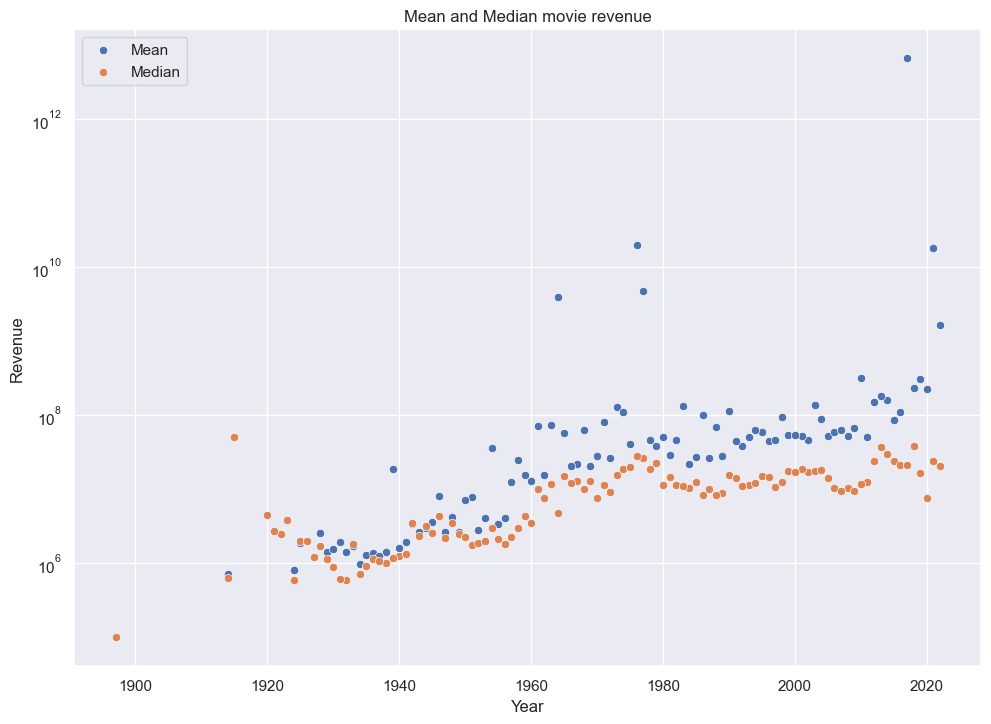

In [8]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
splot = sns.scatterplot(years, mean_revenue,label='Mean')
splot = sns.scatterplot(years, median_revenue,label='Median')
splot.set(yscale="log")
plt.title('Mean and Median movie revenue')
plt.xlabel('Year')
plt.ylabel('Revenue')
plt.show()

/Users/garancehaefliger/opt/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/garancehaefliger/opt/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


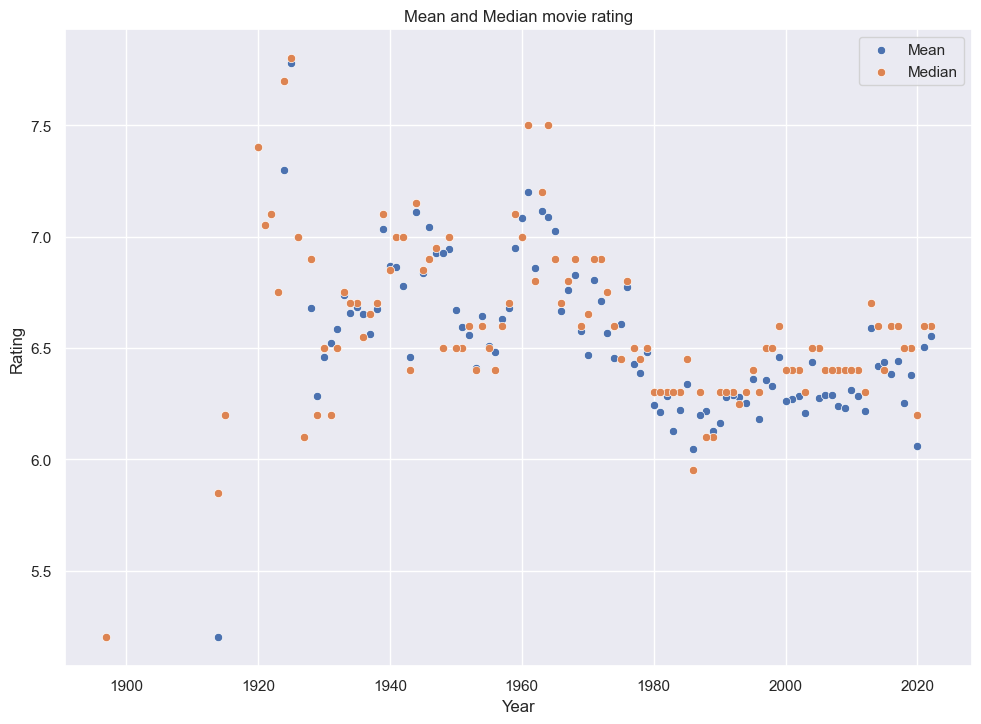

In [9]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
splot = sns.scatterplot(years, mean_rating,label='Mean')
splot = sns.scatterplot(years, median_rating,label='Median')
plt.title('Mean and Median movie rating')
plt.xlabel('Year')
plt.ylabel('Rating')
plt.show()

Let's try to do some statistics. It seems that the mean rating and the mean revenue are not linearly correlated. The median values seem to be significantly correlated but the coefficient is quite small (-0.2).

In [10]:
stats.pearsonr(mean_rating,mean_revenue)

(-0.024219783800475098, 0.8053436101240024)

In [11]:
stats.pearsonr(median_rating,median_revenue)

(-0.20317547616401158, 0.036720608480851395)

In order to really draw conclusion we should take into consideration the inflation!

In [12]:
inflation_revenue = revenue.dropna(subset=['inflation coeff'])

In [14]:
inflation_years = inflation_revenue['Movie release date'].unique()
inflation_mean_revenue = np.zeros_like(inflation_years)
inflation_median_revenue = np.zeros_like(inflation_years)
inflation_mean_rating = np.zeros_like(inflation_years)
inflation_median_rating = np.zeros_like(inflation_years)
for i,y in enumerate(inflation_years):
    
    rev = inflation_revenue.loc[inflation_revenue['Movie release date'] == y]['inflation corrected revenue']
    rat = inflation_revenue.loc[inflation_revenue['Movie release date'] == y]['averageRating']
    
    mean = np.mean(rev)
    median = np.median(rev)
    inflation_mean_revenue[i] = mean
    inflation_median_revenue[i] = median
    
    mean = np.mean(rat)
    median = np.median(rat)
    inflation_mean_rating[i] = mean
    inflation_median_rating[i] = median

/Users/garancehaefliger/opt/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/garancehaefliger/opt/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


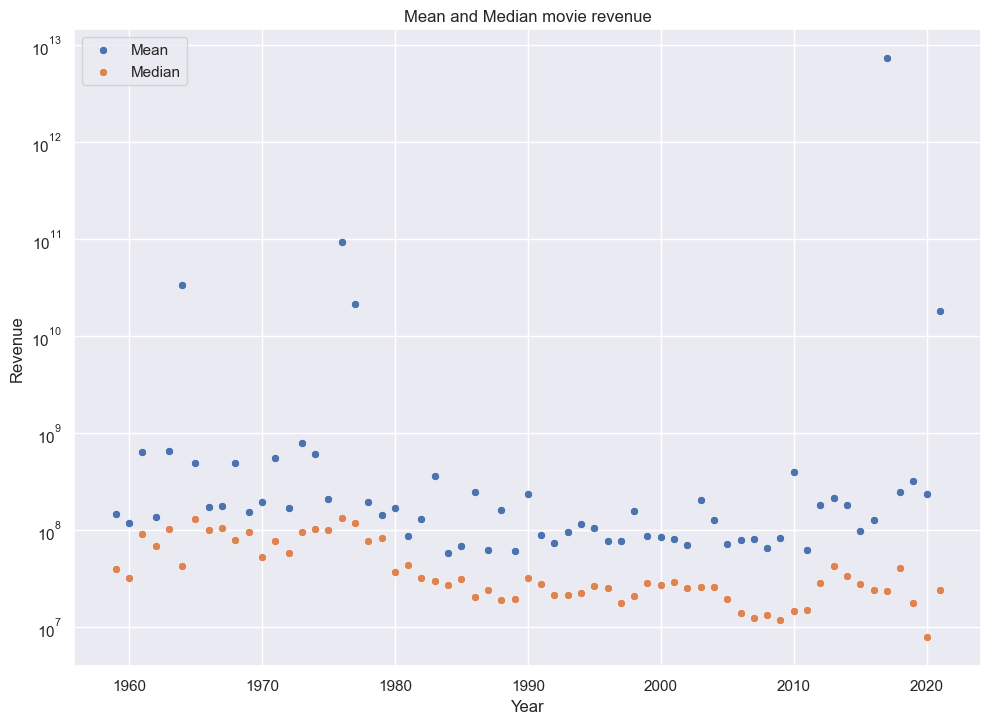

In [15]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
splot = sns.scatterplot(inflation_years, inflation_mean_revenue,label='Mean')
splot = sns.scatterplot(inflation_years, inflation_median_revenue,label='Median')
splot.set(yscale="log")
plt.title('Mean and Median movie revenue')
plt.xlabel('Year')
plt.ylabel('Revenue')
plt.show()

The plot of the revenues corrected with inflation now shows us a more flat regime that without inflation. We can clearly identify some outlines. As a future study it can be nice to analyse which these movies are and why they have such a high revenue.

/Users/garancehaefliger/opt/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/garancehaefliger/opt/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


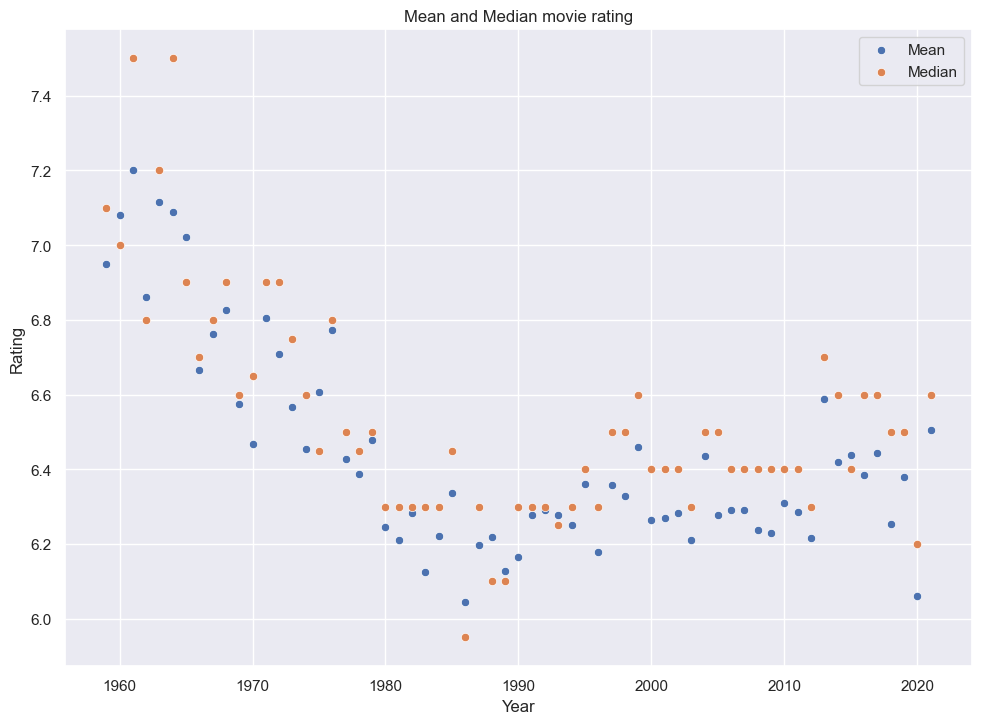

In [16]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
splot = sns.scatterplot(inflation_years, inflation_mean_rating,label='Mean')
splot = sns.scatterplot(inflation_years, inflation_median_rating,label='Median')
plt.title('Mean and Median movie rating')
plt.xlabel('Year')
plt.ylabel('Rating')
plt.show()

Let's try to do some statistics on the corrected revenues. It seems that the mean rating and the mean revenue are not linearly correlated. The median values seem to be significantly correlated with a quite high coefficient (0.54). This gives us the idea that the high revenue is correlated with high rating.

In [17]:
stats.pearsonr(inflation_mean_rating,inflation_mean_revenue)

(0.003967858950730018, 0.9753785198643123)

In [18]:
stats.pearsonr(inflation_median_rating,inflation_median_revenue)

(0.5345058424937271, 6.41412229184206e-06)